In [59]:
#Importing required Lbraries
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import rcParams
rcParams['figure.figsize']=15,7

In [60]:
#Loading dataset
amazon=web.DataReader('AMZN',data_source='yahoo',start='4/6/2006',end='4/6/2018',)
amazon.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2006-04-06,38.840000,37.130001,37.200001,38.509998,9294600,38.509998
2006-04-07,38.669998,37.000000,38.549999,37.090000,5704500,37.090000
2006-04-10,37.279999,36.220001,37.150002,36.610001,4747500,36.610001
2006-04-11,36.750000,35.520000,36.610001,36.060001,6605600,36.060001
2006-04-12,36.439999,35.910000,35.910000,36.130001,2855800,36.130001


In [61]:
#inspecting table
amazon.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3021 entries, 2006-04-06 to 2018-04-06
Data columns (total 6 columns):
High         3021 non-null float64
Low          3021 non-null float64
Open         3021 non-null float64
Close        3021 non-null float64
Volume       3021 non-null int64
Adj Close    3021 non-null float64
dtypes: float64(5), int64(1)
memory usage: 165.2 KB


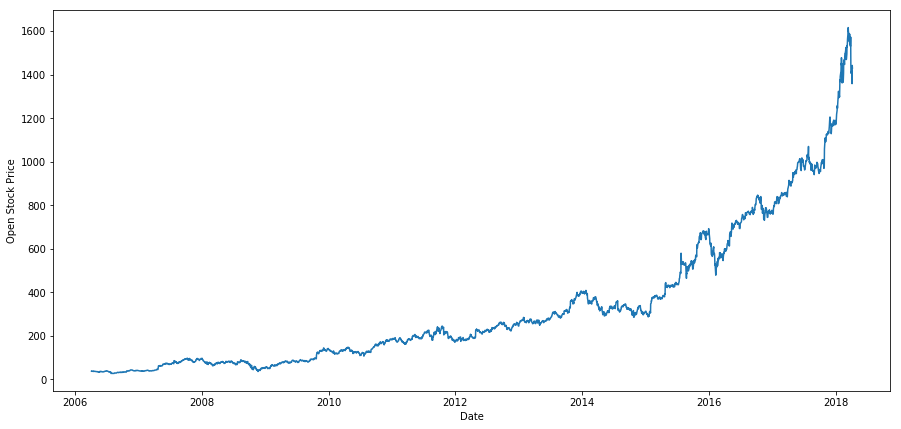

In [62]:
#plotting Open
plt.xlabel('Date')
plt.ylabel('Open Stock Price')
plt.plot(amazon.Open)

In [25]:
#Checking rolling statistics 
rollmean=amazon.rolling(window=12).mean()
rollstd=amazon.rolling(window=12).std()
print(rollmean,rollstd)

                   High          Low         Open        Close        Volume  \
Date                                                                           
2006-04-06          NaN          NaN          NaN          NaN           NaN   
2006-04-07          NaN          NaN          NaN          NaN           NaN   
2006-04-10          NaN          NaN          NaN          NaN           NaN   
2006-04-11          NaN          NaN          NaN          NaN           NaN   
2006-04-12          NaN          NaN          NaN          NaN           NaN   
2006-04-13          NaN          NaN          NaN          NaN           NaN   
2006-04-17          NaN          NaN          NaN          NaN           NaN   
2006-04-18          NaN          NaN          NaN          NaN           NaN   
2006-04-19          NaN          NaN          NaN          NaN           NaN   
2006-04-20          NaN          NaN          NaN          NaN           NaN   
2006-04-21          NaN          NaN    

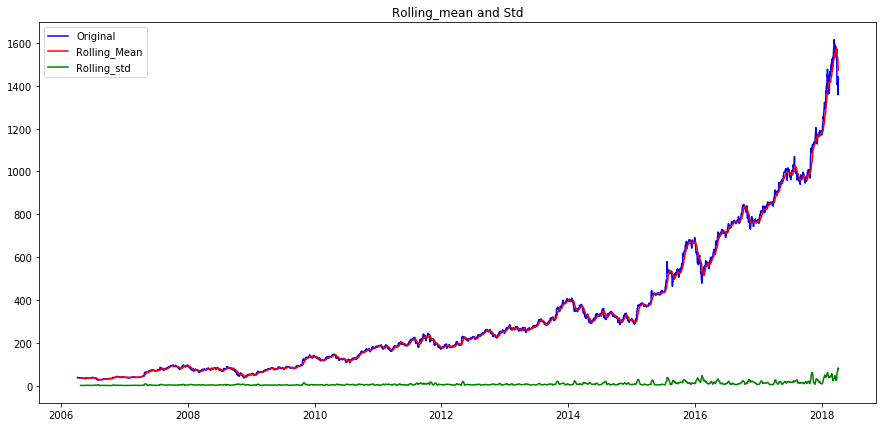

In [63]:
#plottin rolling data
original=plt.plot(amazon.Open,color='blue',label='Original')
rollig_mean=plt.plot(rollmean.Open,color='red',label='Rolling_Mean')
std=plt.plot(rollstd.Open,color='green',label='Rolling_std')
plt.legend(loc='best')
plt.title('Rolling_mean and Std')
plt.show()

In [75]:
#Using Adfuller test to check for stationarity  of data
from statsmodels.tsa.stattools import adfuller
adfuller_test=adfuller(amazon['Open'])

adfuller_results = pd.Series(adfuller_test[0:4],index=['Statistics','P-value','lags used','Observations_used'])
print(adfuller_results)

Statistics              3.138144
P-value                 1.000000
lags used              26.000000
Observations_used    2994.000000
dtype: float64


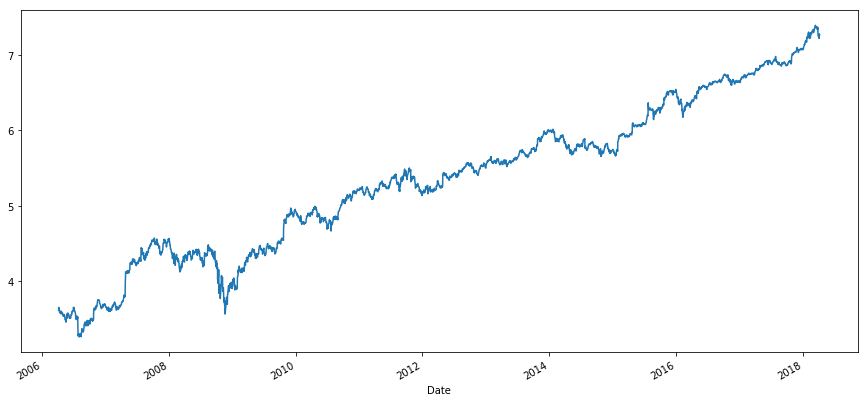

In [82]:
# As observed the P value is very high so we can not reject null hypothesis implying data is not stationary.
#Trend Estimation
amazon_log=np.log(amazon['Open'])
amazon_log.plot()

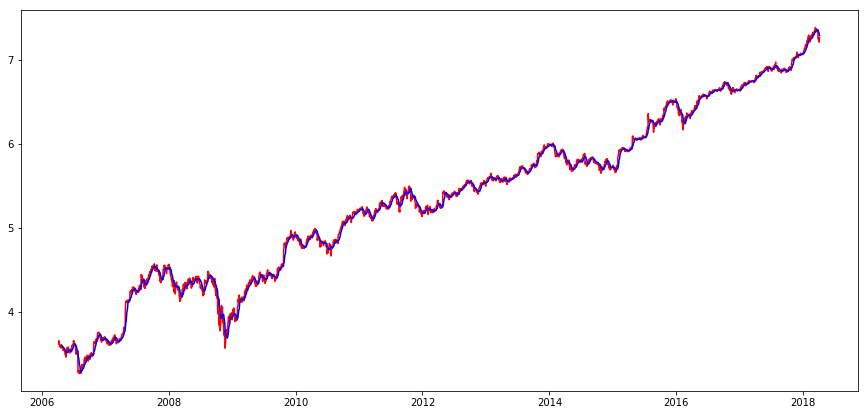

In [99]:
MovingAverage=amazon_log.rolling(window=12).mean()
Movingstd=amazon_log.rolling(window=12).std()
figure=plt.figure()
plt.plot(amazon_log,color='red')
plt.plot(MovingAverage,color='blue')
plt.show()

In [89]:
MovingAverage

Date
2006-04-06         NaN
2006-04-07         NaN
2006-04-10         NaN
2006-04-11         NaN
2006-04-12         NaN
2006-04-13         NaN
2006-04-17         NaN
2006-04-18         NaN
2006-04-19         NaN
2006-04-20         NaN
2006-04-21         NaN
2006-04-24    3.598890
2006-04-25    3.595203
2006-04-26    3.587958
2006-04-27    3.584195
2006-04-28    3.582261
2006-05-01    3.580573
2006-05-02    3.577480
2006-05-03    3.572344
2006-05-04    3.570510
2006-05-05    3.567048
2006-05-08    3.563072
2006-05-09    3.557909
2006-05-10    3.554518
2006-05-11    3.551003
2006-05-12    3.546697
2006-05-15    3.539444
2006-05-16    3.532322
2006-05-17    3.525567
2006-05-18    3.518202
                ...   
2018-02-23    7.270501
2018-02-26    7.273893
2018-02-27    7.279244
2018-02-28    7.287663
2018-03-01    7.296295
2018-03-02    7.301152
2018-03-05    7.306209
2018-03-06    7.309893
2018-03-07    7.313757
2018-03-08    7.319516
2018-03-09    7.323809
2018-03-12    7.329059
2018-0